In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [127]:
train = pd.read_csv("Data/train.csv").drop(columns="Unnamed: 0")
test = pd.read_csv("Data/test.csv").drop(columns="Unnamed: 0")
train.head()

,date,905270,921795,904261,905261,916328,923024,936365,902355,912215,...,9889RL,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
0,1990-01-02,22.75,12.63,30.00,29.61,3.8736,11.00,4.1250,24.50,58.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-03,22.56,12.57,31.50,29.37,3.8876,11.00,4.0000,24.50,57.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-01-04,22.38,12.41,32.25,28.89,3.8806,11.38,3.9375,24.63,57.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-01-05,21.81,12.60,32.13,28.41,3.8387,11.50,3.8125,24.75,57.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-01-08,22.25,12.49,32.13,29.13,3.8387,11.50,3.8125,25.00,57.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
train["date"] = pd.to_datetime(train["date"], format="%Y-%m-%d")
test["date"] = pd.to_datetime(test["date"], format="%Y-%m-%d")

In [129]:
# Running linear regression on a sample stock

sample = train[["date", "936365"]]
sample["936365_lag1"] = train["936365"].shift(-1)
sample

,date,936365,936365_lag1
0,1990-01-02,4.1250,4.0000
1,1990-01-03,4.0000,3.9375
2,1990-01-04,3.9375,3.8125
3,1990-01-05,3.8125,3.8125
4,1990-01-08,3.8125,3.8750
...,...,...,...
6326,2015-02-09,3.0400,3.0400
6327,2015-02-10,3.0400,3.0700
6328,2015-02-11,3.0700,3.1200
6329,2015-02-12,3.1200,3.1500


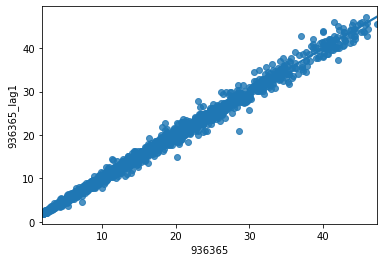

In [130]:
sns.regplot(data=sample, x="936365", y="936365_lag1")

In [131]:
sample["936365"].isna().value_counts()

False    6331
Name: 936365, dtype: int64

In [132]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
lag = 1
new_df = sample.iloc[:-1, :]
model.fit(X=new_df[["936365"]], y=new_df["936365_lag1"])

LinearRegression()

In [133]:
print("Line formula for 936365: \ncurrent price = " + str(model.intercept_) + " + " +
      str(model.coef_[0]) + " * prev price")

Line formula for 936365: 
current price = 0.028297530216166322 + 0.9974971975060474 * prev price


In [134]:
# Predicting for a single stock
import datetime

total_predictions = pd.DataFrame()

next_days = 10
lag = 1
stock_predictions = []
for day in range(next_days):
    model = LinearRegression()
    new_df = sample.iloc[:-1, :]
    model.fit(X=new_df[["936365"]], y=new_df["936365_lag1"])
    current_price = sample[["936365"]].iloc[-1][0]
    next_pred = model.predict(pd.DataFrame([[current_price]]))[0]
    next_day = sample[["date"]].iloc[-1][0] + datetime.timedelta(days=1)
    sample["936365_lag1"].fillna(next_pred, inplace=True)
    sample = sample.append(pd.DataFrame({"date": [next_day], 
                                         "936365": [next_pred], 
                                         "936365_lag1": [np.nan]})).reset_index(drop=True)
    stock_predictions.append(next_pred)
    
total_predictions["936365"] = stock_predictions
total_predictions

,936365
0,3.170414
1,3.190776
2,3.211088
3,3.231349
4,3.251559
5,3.271718
6,3.291827
7,3.311886
8,3.331895
9,3.351853


In [149]:
# Filtering for only listed stocks
listed_stocks = train.loc[:, ~train.iloc[-1].isnull()].columns
listed_stocks

Index(['date', '905270', '921795', '904261', '905261', '916328', '923024',
       '936365', '902355', '912215',
       ...
       '311917', '69568X', '543755', '77463M', '29235J', '131745', '69487D',
       '68157P', '9110RA', '292703'],
      dtype='object', length=1215)

In [ ]:
# Parameters for prediction model
total_predictions = pd.DataFrame()

next_days = 10
lag = 1

In [166]:
print?

In [169]:
# Running predictions for all stocks
count = 1
for stock in listed_stocks[1:100]:
    sample = train[["date", stock]].dropna()
    sample[stock + "_lag1"] = train[stock].shift(-1)
    stock_predictions = []
    for day in range(next_days):
        model = LinearRegression()
        new_df = sample.iloc[:-1, :]
        model.fit(X=new_df[[stock]], y=new_df[stock + "_lag1"])
        current_price = sample[[stock]].iloc[-1][0]
        next_pred = model.predict(pd.DataFrame([[current_price]]))[0]
        next_day = sample[["date"]].iloc[-1][0] + datetime.timedelta(days=1)
        sample[stock + "_lag1"].fillna(next_pred, inplace=True)
        sample = sample.append(pd.DataFrame({"date": [next_day], 
                                             stock: [next_pred], 
                                             stock + "_lag1": [np.nan]})).reset_index(drop=True)
        stock_predictions.append(next_pred)
    total_predictions[stock] = stock_predictions
    print(count, end=" ")
    count += 1

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [170]:
total_predictions

,936365,905270,921795,904261,905261,916328,923024,902355,912215,929813,...,901893,905845,921153,906186,902287,936872,901894,906171,905105,905274
0,3.170414,53.807069,11.396142,29.682764,20.358874,46.094613,30.000514,57.937995,68.123061,52.310420,...,1.380005,52.882441,69.457747,23.001246,54.809913,42.276541,79.377976,52.247210,122.716956,23.457691
1,3.190776,53.804142,11.402273,29.675561,20.367739,46.099226,30.001029,57.935991,68.116141,52.310839,...,1.380010,52.884882,69.455494,23.002484,54.809826,42.273083,79.375953,52.244424,122.834031,23.545247
2,3.211088,53.801217,11.408394,29.668391,20.376593,46.103838,30.001543,57.933988,68.109240,52.311258,...,1.380014,52.887322,69.453243,23.003716,54.809739,42.269627,79.373932,52.241640,122.951224,23.632668
3,3.231349,53.798296,11.414505,29.661254,20.385437,46.108451,30.002056,57.931987,68.102356,52.311677,...,1.380019,52.889761,69.450992,23.004940,54.809652,42.266172,79.371912,52.238859,123.068536,23.719954
4,3.251559,53.795379,11.420605,29.654149,20.394271,46.113062,30.002570,57.929988,68.095492,52.312096,...,1.380024,52.892199,69.448742,23.006157,54.809566,42.262718,79.369894,52.236081,123.185968,23.807105
5,3.271718,53.792464,11.426696,29.647076,20.403095,46.117674,30.003083,57.927991,68.088645,52.312515,...,1.380028,52.894636,69.446494,23.007368,54.809479,42.259267,79.367877,52.233306,123.303518,23.894122
6,3.291827,53.789553,11.432776,29.640035,20.411908,46.122285,30.003596,57.925994,68.081818,52.312933,...,1.380033,52.897073,69.444246,23.008571,54.809392,42.255816,79.365862,52.230534,123.421188,23.981004
7,3.311886,53.786644,11.438846,29.633026,20.420712,46.126896,30.004108,57.924000,68.075008,52.313351,...,1.380038,52.899509,69.441999,23.009767,54.809305,42.252367,79.363848,52.227764,123.538978,24.067752
8,3.331895,53.783739,11.444905,29.626050,20.429506,46.131506,30.004621,57.922007,68.068216,52.313769,...,1.380042,52.901944,69.439752,23.010957,54.809218,42.248920,79.361836,52.224998,123.656886,24.154367
9,3.351853,53.780838,11.450955,29.619104,20.438289,46.136116,30.005133,57.920015,68.061443,52.314187,...,1.380047,52.904378,69.437507,23.012139,54.809132,42.245474,79.359825,52.222234,123.774915,24.240847
